In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [2]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
_exp_name = "sample of 12"

In [5]:
# gray_tfm = transforms.Grayscale(num_output_channels=1)

train_tfm = transforms.Compose([
    transforms.Resize((84, 84)),
#     gray_tfm,
#     transforms.RandomResizedCrop((64, 64), scale=(0.7, 1.0)),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
#     transforms.RandomRotation(180),
#     transforms.RandomAffine(30),
    
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((84, 84)),
#     gray_tfm,
    transforms.ToTensor(),
])

In [6]:
class MYDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(MYDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("\\")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 84, 84]               
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 42, 3, 1, 1),  # [42, 84, 84]
            nn.BatchNorm2d(42),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [42, 42, 42]

            nn.Conv2d(42, 128, 3, 1, 1), # [128, 42, 42] 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 21, 21]  

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 21, 21]  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, 3, 0),       # [256, 7, 7] 
            
        )
        self.fc = nn.Sequential(
            nn.Linear(256*7*7, 4096),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(4096, 256),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [8]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(42, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=4096, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): ReLU()
    (3): Linear(in_featur

In [9]:
# 冻结预训练模型的权重
for param in model.parameters():
    param.requires_grad = False

# 添加新的全连接层
model.fc = nn.Sequential(
    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 4)
)
# 解冻新的全连接层
for param in model.fc.parameters():
    param.requires_grad_()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(42, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_featur

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [12]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
# print(model)

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 20 #8

# If no improvement in 'patience' epochs, early stop.
patience = 12 #5

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [13]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = MYDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = MYDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [14]:
img, label = train_set[48]
print(img.shape, label)
img

torch.Size([3, 84, 84]) 0


tensor([[[0.4353, 0.3529, 0.3529,  ..., 0.5490, 0.6863, 0.6627],
         [0.3725, 0.3137, 0.4431,  ..., 0.5176, 0.6745, 0.6667],
         [0.4039, 0.3608, 0.5020,  ..., 0.4667, 0.4941, 0.4824],
         ...,
         [0.6314, 0.4941, 0.5020,  ..., 0.3961, 0.6431, 0.7725],
         [0.5647, 0.4471, 0.5294,  ..., 0.5255, 0.5765, 0.5608],
         [0.3569, 0.4627, 0.6980,  ..., 0.4706, 0.4902, 0.5137]],

        [[0.6431, 0.5961, 0.5529,  ..., 0.4745, 0.6510, 0.6627],
         [0.5255, 0.3765, 0.4000,  ..., 0.5569, 0.7098, 0.7020],
         [0.3961, 0.2353, 0.3098,  ..., 0.5647, 0.5608, 0.5176],
         ...,
         [0.6314, 0.4980, 0.4980,  ..., 0.3843, 0.6431, 0.7725],
         [0.6549, 0.4431, 0.4353,  ..., 0.5490, 0.5686, 0.5373],
         [0.4941, 0.4549, 0.5569,  ..., 0.5216, 0.4902, 0.4745]],

        [[0.5647, 0.5451, 0.5647,  ..., 0.4078, 0.4980, 0.4510],
         [0.5137, 0.3765, 0.4235,  ..., 0.5255, 0.6980, 0.6980],
         [0.4157, 0.2549, 0.3255,  ..., 0.5843, 0.6627, 0.

Label:  0
torch.Size([84, 84, 3])


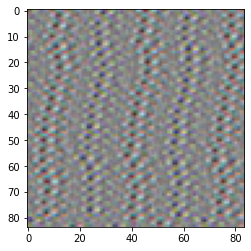

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# image,label = train_set[0]
# print(image.shape)
# print('Label: ', label)
# plt.imshow(img.permute(1, 2, 0))

image, label = train_set[0]
image = np.transpose(image, (1, 2, 0)) # 从 [3, 84, 64] 变为 [84, 84, 3]
plt.imshow(image)
print('Label: ', label)
print(image.shape)

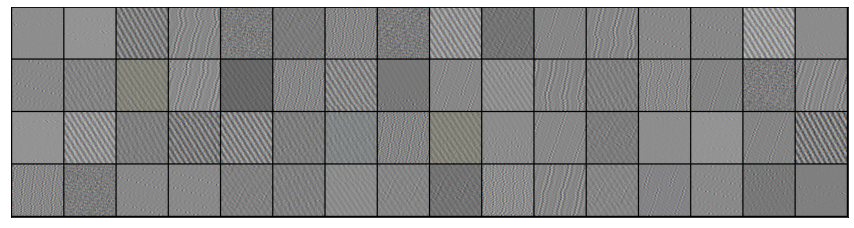

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_loader)

In [17]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
train_losses = []
val_losses = []
val_accur = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
#         imgs = imgs.half()
#         print(imgs.shape,labels.shape)
#         print(labels)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_losses.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    val_losses.append(valid_loss)
    val_accur.append(valid_acc)
    
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs                    
#Logging: The code logs the training and validation loss and accuracy at each epoch.记录日志：代码在每个epoch记录训练和验证损失和准确性。
#     if valid_acc > best_acc:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
#     else:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt", "a") as f:
            message = f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n"
            f.write(message)
            print(message, end="")
    else:
        with open(f"./{_exp_name}_log.txt", "a") as f:
            message = f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}\n"
            f.write(message)
            print(message, end="")

    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_overbest.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/29 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)